#  *Discovering Deep Learning with MNIST Fashion Image Classification*

- *Aim:* this project aims to build accurate as possible a perceptron and a CNN model, to classify fashion images from the MNIST Fashion dataset.  


## Loading and visualizing the data

We will consider the MNIST database which contains 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. In a first time, we load the data.

In [1]:
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, InputLayer,ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical, plot_model
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
import numpy as np
from tensorflow.keras import backend as K

In [2]:
def loadMNISTAsVector(subset=10000) :
    nb_classes=10
    (X_train_img, y_train_real), (X_test_img, y_test_real) = fashion_mnist.load_data()
    X_train_vect = X_train_img[:subset].reshape(subset, 784)
    X_test_vect = X_test_img.reshape(10000, 784)
    X_train_vect = X_train_vect.astype("float32")
    X_test_vect = X_test_vect.astype("float32")
    X_train_vect /= 255
    X_test_vect /= 255
    y_train_cat = to_categorical(y_train_real[:subset], nb_classes)
    y_test_cat = to_categorical(y_test_real, nb_classes)
    return (X_train_vect, y_train_cat), (X_test_vect, y_test_cat)



(X_train_vect, y_train_cat), (X_test_vect, y_test_cat) =loadMNISTAsVector(subset=50000) #to limit the wating time, as first step we can just load 10000 samples


4422102/4422102 [==============================] - 0s 0us/step


Ploting the data
   

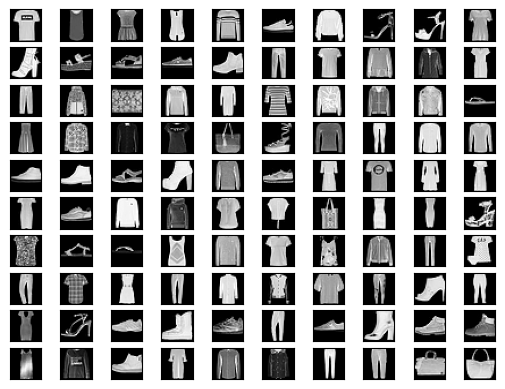

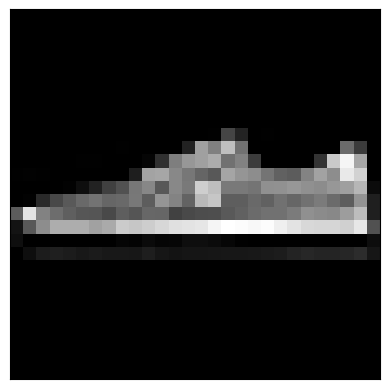

In [3]:
def plot_10_by_10_images(images):
    """ Plot 100 MNIST images in a 10 by 10 table. Note that we crop
    the images so that they appear reasonably close together.  The
    image is post-processed to give the appearance of being continued."""
    fig = plt.figure()
    #image = np.concatenate(images, axis=1)
    for x in range(10):
        for y in range(10):
            ax = fig.add_subplot(10, 10, 10*y+x+1)
            plt.imshow(images[10*y+x+1].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

def plot_mnist_digit(image):
    """ Plot a single MNIST image."""
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.imshow(image.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()



plot_10_by_10_images(X_train_vect)

plot_mnist_digit(X_train_vect[14])

In [4]:
X_train_vect.shape, X_test_vect.shape

((50000, 784), (10000, 784))

In [5]:
y_train_cat.shape, y_train_cat.shape #10 classes

((50000, 10), (50000, 10))

In [6]:
print(X_train_vect.min(), X_train_vect.max())  #values comprised between 0 and 1

0.0 1.0


As we can see, the datasets reprsented as vectors, we have a train_set of 50,000 samples and a test_set of 10,000 of samples, and 784 features, we have 10 classes to classify, the data is scaled to have values between 0.0 as min and 1.0 as max.

## Learning the network

The next task is to build the network.

In the learn model function, the neural networks shape is obtained by using the keras functions :
* __model.add(InputLayer(shape=(nbinput,)))__ : which adds an yhe imput layer to the network. [input_shape=(nbinput,)] corresponds to the shape of the input data
* __model.add(Dense(nbhiden, [activation='activationfunction']))__ : which adds an hidden layer to the network. nbhidden is the number of hidden nodes.  [activation='activationfunction'] is the activation function of the layer
* __model.add(Dropout(value))__ : apply dropout to the layer (to avoid overfitting)
* __model.add(BatchNormalization())__: apply batch normalization to the layer (to avoid overfitting)

The possible activation fonctions are :
* Relu
* Sigmoid
* softmax (for the slast layer of a multiclass classifier)

The possible loss functions are
* binary_crossentropy (for binary classification)
* categorical_cross_entropy (for multi class classification)
* mean_squared_error (for regression)


In [7]:
def getSimplePerceptron(nb_classes=10):
    model = Sequential()
    model.add(InputLayer(input_shape=(784)))                  #input layer ~ features

    layers = [2048, 2048]                                     #hidden layer
    for l in layers:
      model.add(Dense(l,activation="linear"))                 # add linear function
      model.add(BatchNormalization())                         # add a batchnormalization to normalize the activation
      model.add(ReLU())
      model.add(Dropout(0.75))                                # add a dropout to prevent overfitting

    model.add(Dense(nb_classes, activation='softmax'))

    opt = Adam(lr= 0.0001)                                    # config the optimizer with learing rate of 0.0001
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],  optimizer=opt)
    return model

model_simple=getSimplePerceptron()
model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              1607680   
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                       

\__ Description of the neural newtwork __:

The Neural Network above is composed of three types of layers;
- first layer represent the input layer which takes the input features (784).
- second we have 2 hidden layers of 2048 units.
- third we have the output layer (Dense) with 10 units (10 classes).

The number of parameters is computed by the total number of weights + the total number of biases. The total number of weights equals the sum of the products of each pair of adjacent layers. The total number of biases is equal to the number of hidden neurons + the number of output neurons.

* total_weights = (784 * 2048)+ (2048 *2048)+ (2048 * 10)
* total_biases = 2048 + 2048 + 10
* total_parameters = 5832714

Then, we learn the parameters of the network

In [8]:
(X_train_vect, y_train_cat), (X_test_vect, y_test_cat) =loadMNISTAsVector()
model=getSimplePerceptron()
batch_size = 64
epochs=25
res = model_simple.fit(X_train_vect, y_train_cat, batch_size=batch_size, epochs=epochs,  verbose=1, validation_data=(X_test_vect, y_test_cat))

Epoch 1/25
157/157 [==============================] - 12s 10ms/step - loss: 1.1664 - accuracy: 0.6633 - val_loss: 0.7619 - val_accuracy: 0.7609
Epoch 2/25
157/157 [==============================] - 2s 10ms/step - loss: 0.8042 - accuracy: 0.7466 - val_loss: 0.7468 - val_accuracy: 0.7926
Epoch 3/25
157/157 [==============================] - 2s 10ms/step - loss: 0.7019 - accuracy: 0.7701 - val_loss: 0.5982 - val_accuracy: 0.8133
Epoch 4/25
157/157 [==============================] - 2s 13ms/step - loss: 0.6295 - accuracy: 0.7866 - val_loss: 0.5636 - val_accuracy: 0.8280
Epoch 5/25
157/157 [==============================] - 3s 18ms/step - loss: 0.6041 - accuracy: 0.7975 - val_loss: 0.5015 - val_accuracy: 0.8327
Epoch 6/25
157/157 [==============================] - 2s 14ms/step - loss: 0.5518 - accuracy: 0.8088 - val_loss: 0.5256 - val_accuracy: 0.8265
Epoch 7/25
157/157 [==============================] - 1s 9ms/step - loss: 0.5298 - accuracy: 0.8131 - val_loss: 0.4898 - val_accuracy: 0.8309

## Evaluate The Performances

Plot the train/test curve of the loss and accuracy

Best test accuracy was 0.852500 at epoch 25


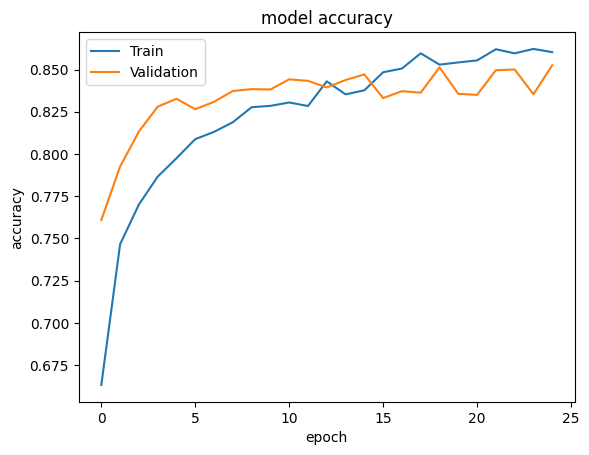

In [9]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(res.history['accuracy'])
plt.plot(res.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



best_score = max(res.history['val_accuracy'])
best_epoch = np.array(res.history['val_accuracy']).argmax()+1
print('Best test accuracy was %f at epoch %i' % (best_score, best_epoch))



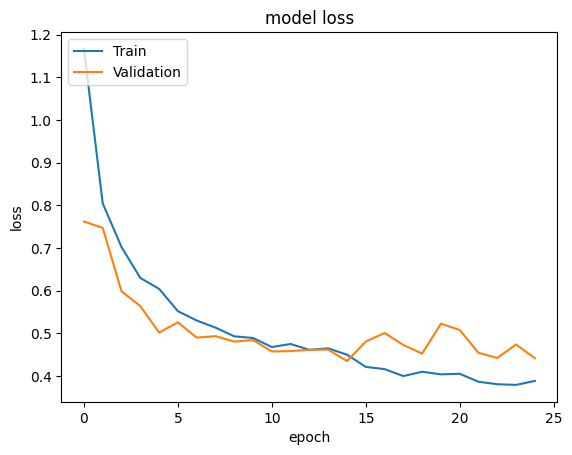

In [10]:
# summarize history for loss
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Last, we analyse the results :

In [11]:
loss_simple,acc_simple = model_simple.evaluate(X_test_vect, y_test_cat,  verbose=0)
index=800
print('The accuracy on the test set is ',(acc_simple*100),'%')

The accuracy on the test set is  85.25000214576721 %


Predict the probabilty distribution on the classes for one image with the function predict and find the most probable class

In [12]:
np.where(y_test_cat[0] == 1)[0][0]  #let's check if the model find the class of the first item

9

In [13]:
y_pred = model_simple.predict(X_test_vect)
y_pred[0]

313/313 [==============================] - 1s 2ms/step


array([1.0660863e-06, 1.9136124e-07, 4.5396655e-06, 3.3089411e-06,
       1.2471711e-05, 1.7371161e-02, 1.2916725e-05, 1.1722998e-01,
       1.3952126e-04, 8.6522478e-01], dtype=float32)

In [14]:
np.where(y_pred[0]==y_pred[0].max())[0][0]  #find the index of the max value (most probable class)
# the model predict correctely the class for the first item

9

## Convolutional Neural Network : CNN

We will now consider a new kind of network that consider image directly. We load the data as matrix instead of vectors

In [15]:
def loadMNISTAsMaxtrix(subset=10000) :
    nb_classes=10
    img_rows, img_cols = 28, 28
    (X_train_img, y_train_real), (X_test_img, y_test_real) = fashion_mnist.load_data()
    X_train_mat = X_train_img[:subset].reshape(X_train_img[:subset].shape[0], img_rows, img_cols, 1)
    X_test_mat = X_test_img.reshape(X_test_img.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    X_train_mat = X_train_mat.astype('float32')
    X_test_mat = X_test_mat.astype('float32')
    X_train_mat /= 255
    X_test_mat /= 255
    y_train_cat = to_categorical(y_train_real[:subset], nb_classes)
    y_test_cat = to_categorical(y_test_real, nb_classes)
    return (X_train_mat, y_train_cat), (X_test_mat, y_test_cat)


In [16]:
(X_train_mat, y_train_cat), (X_test_mat, y_test_cat) =loadMNISTAsMaxtrix(subset=50000)

Compare the shape of the data with the previous approach:

> The main difference between these two approaches is that in the first, data are loaded as 2D vectors, whereas in the second, data are loaded as matrices.



In [17]:
X_train_vect[50]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00392157, 0.        ,
       0.        , 0.03529412, 0.02352941, 0.        , 0.        ,
       0.        , 0.09411765, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.2627451 , 0.81960785, 0.90588236,
       0.972549  , 0.9882353 , 0.98039216, 0.99215686, 0.9647059 ,
       0.80784315, 0.5176471 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00392157,
       0.8901961 , 0.9529412 , 0.91764706, 0.91764706, 0.972549  ,
       0.9647059 , 0.93333334, 0.9019608 , 0.91764706, 0.98039

Print the shape of the data and comment it.

In [18]:
X_train_mat.shape

(50000, 28, 28, 1)

The shape is represented in 4D, where the first element represent the number of samples, and 28x28 represent the dimenssion of the images, and 1 represent the color, here form gray to white.

The next task is to build the convolutional neural network (CNN).
In the learn model function, the CNN shape is obtained by using these additional keras functions :
* __model.add(InputLayer(shape=(nbinput,)))__ : which adds an yhe imput layer to the network. [input_shape=(nbinput,)] corresponds to the shape of the input data
* __model.add(Conv2D(nbhiden, [kernel_size=(3, 3)], [padding='same'], [activation='activationfunction']))__ : which adds an convolution hidden layer to the network. nbhidden is the number of hidden nodes.  [kernel_size=(3, 3)] the size of the convolutional kernel and [padding='same'] the way the border of the images are handled
* __model.add(MaxPooling2D(pool_size=(2, 2))__ : pooling operation



In [19]:
def getCNN(nb_classes=10):
    model = Sequential()
    model.add(InputLayer(input_shape=(28,28,1)))                                          #matrix of 28x28 indicating 28x28 grayscale images


    for l in [64, 128]:
      for m in range(3):
        model.add(Conv2D(l, kernel_size=(3, 3), padding='same', activation= 'linear'))    # add convolution layer
        model.add(BatchNormalization())                                                   #add a BatchNormalization to normalize activations
        model.add(ReLU())                                                                 #add a relu function, a rectified linear
      model.add(MaxPooling2D(pool_size=(2, 2)))                                           ##pooling to downsample the data


    model.add(Flatten())                                                                  #transform image to vectors of neurons
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(nb_classes, activation='softmax'))                                    # output layer

    opt = Adam(0.0001)                                                                    # adam optimizer with leanring rate of 0.0001
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],  optimizer=opt)
    return model


model_cnn=getCNN(nb_classes=10)
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_4 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_5 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 re_lu_5 (ReLU)              (None, 28, 28, 64)       

In [20]:
batch_size = 256
epochs=20
cnn = model_cnn.fit(X_train_mat, y_train_cat, batch_size=batch_size, epochs=epochs,  verbose=1, validation_data=(X_test_mat, y_test_cat))

Epoch 1/20
196/196 [==============================] - 24s 70ms/step - loss: 0.4991 - accuracy: 0.8240 - val_loss: 2.4366 - val_accuracy: 0.1003
Epoch 2/20
196/196 [==============================] - 13s 68ms/step - loss: 0.2708 - accuracy: 0.9030 - val_loss: 1.8005 - val_accuracy: 0.4701
Epoch 3/20
196/196 [==============================] - 13s 65ms/step - loss: 0.2060 - accuracy: 0.9254 - val_loss: 0.3729 - val_accuracy: 0.8647
Epoch 4/20
196/196 [==============================] - 13s 66ms/step - loss: 0.1647 - accuracy: 0.9424 - val_loss: 0.2609 - val_accuracy: 0.9069
Epoch 5/20
196/196 [==============================] - 15s 77ms/step - loss: 0.1319 - accuracy: 0.9551 - val_loss: 0.2666 - val_accuracy: 0.9048
Epoch 6/20
196/196 [==============================] - 14s 69ms/step - loss: 0.0976 - accuracy: 0.9691 - val_loss: 0.2813 - val_accuracy: 0.9055
Epoch 7/20
196/196 [==============================] - 13s 68ms/step - loss: 0.0712 - accuracy: 0.9794 - val_loss: 0.2700 - val_accuracy:

__Questions__ : As for the dense networks, do the following analysis :
* Plot the train/test curve of the loss and accuracy
* Compute the final accuracy on the test set
* Predict the probabilty distribution on the classes for one image with the function predict and find the most probable class


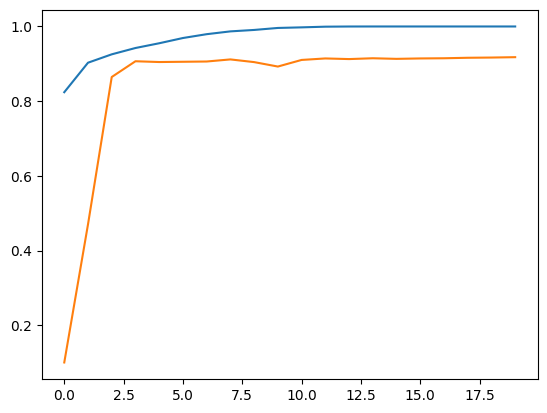

In [21]:
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])

In [22]:
loss_cnn,acc_cnn = model_cnn.evaluate(X_test_mat, y_test_cat,  verbose=0)
index=800
print('The accuracy on the test set is ',(acc_cnn*100),'%')

The accuracy on the test set is  91.78000092506409 %


As we can see with the CNN we get a best accuracy on the test set than the simple model

In [23]:
model_cnn.predict(X_test_mat)

313/313 [==============================] - 1s 3ms/step


array([[4.18331592e-10, 4.17820856e-12, 3.90037612e-12, ...,
        1.51271820e-07, 9.78086501e-09, 9.99995112e-01],
       [1.79956587e-05, 1.67930669e-11, 9.99980688e-01, ...,
        2.23748756e-10, 1.01141040e-09, 3.96280092e-11],
       [5.42655476e-09, 1.00000000e+00, 7.79442483e-13, ...,
        1.76092266e-11, 4.67556271e-10, 4.32837620e-12],
       ...,
       [6.33998354e-07, 3.61651709e-10, 1.49473863e-06, ...,
        3.16426468e-10, 9.99997854e-01, 1.08026886e-10],
       [4.12965306e-08, 9.99999881e-01, 3.92631969e-11, ...,
        1.13775178e-09, 5.05310211e-08, 1.62225799e-09],
       [4.89859158e-05, 1.15463183e-06, 1.28034583e-06, ...,
        8.43454003e-02, 2.31234487e-02, 1.07304440e-05]], dtype=float32)

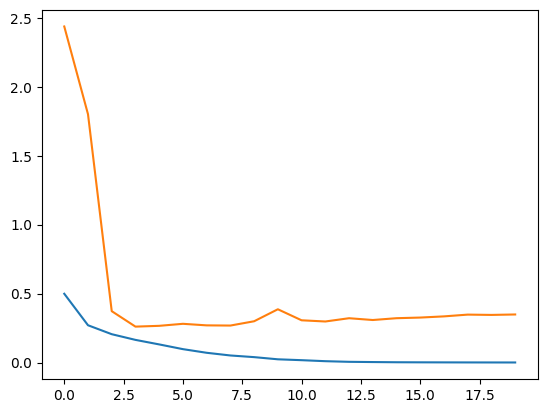

In [24]:
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])

In [25]:
y_predictions = model_cnn.predict(X_test_mat)

313/313 [==============================] - 1s 3ms/step


In [26]:
y_predictions[0]

array([4.1833159e-10, 4.1782086e-12, 3.9003761e-12, 4.6420220e-10,
       1.0150211e-10, 4.7624130e-06, 2.3608362e-10, 1.5127182e-07,
       9.7808650e-09, 9.9999511e-01], dtype=float32)

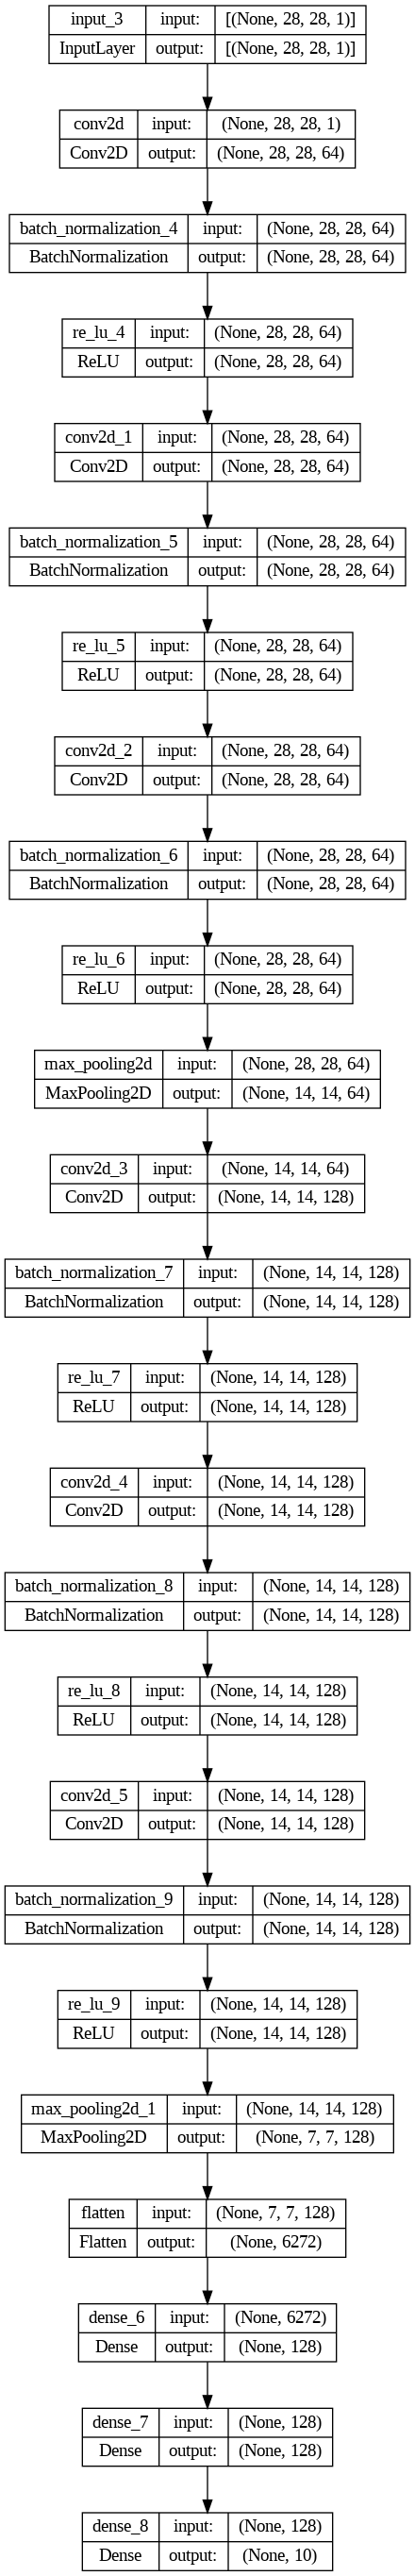

In [27]:
plot_model(model_cnn, show_shapes=True, show_layer_names=True)

In [28]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 9.3 MB/s eta 0:00:00


Plotting the CNN model with visualkeras

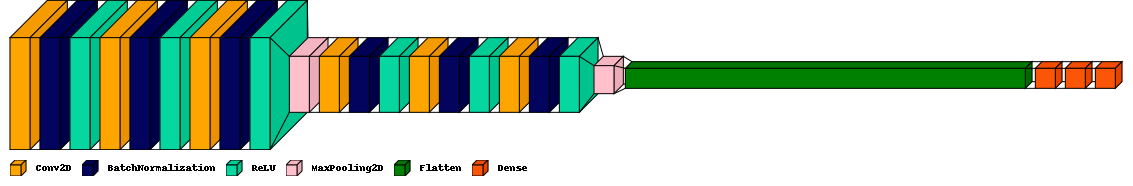

In [36]:
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict
import visualkeras
from tensorflow.keras import layers
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'orange'
color_map[layers.MaxPooling2D]['fill'] = 'pink'
color_map[layers.BatchNormalization]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = 'green'
visualkeras.layered_view(model_cnn, legend=True,color_map=color_map)



__Questions__ : Compare the results of the two types of networks with respect to their performances and their number of parameters. Use bar plot to compare the different models you applied

Text(0.5, 1.0, 'Accuracy Comparison: CNN vs. Simple Network')

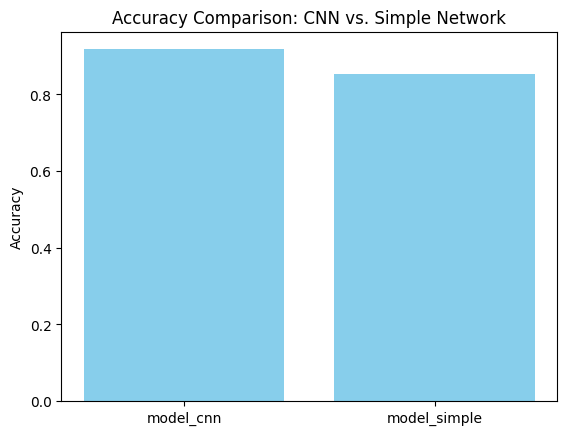

In [37]:
plt.bar(['model_cnn', 'model_simple'], [acc_cnn, acc_simple], color='skyblue')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: CNN vs. Simple Network')

Text(0.5, 1.0, 'Loss Comparison: CNN vs. Simple Network')

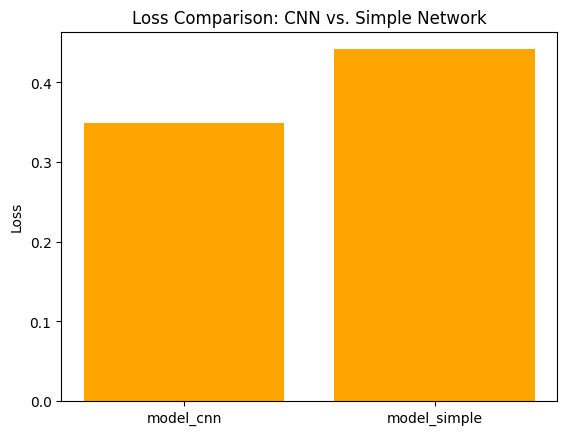

In [38]:
plt.bar(['model_cnn', 'model_simple'], [loss_cnn, loss_simple], color='orange')
plt.ylabel('Loss')
plt.title('Loss Comparison: CNN vs. Simple Network')

Visually we can say that the CNN model is more efficient than the perceptron, also it's more accurate and has loss less than the perceptron model.
We could have done a statistical test to confirm this, but as we already know, that the CNN model is more suitable than the simple perceptron model, this is not necessary.
This beacause the cnn model uses convolutional layers to detect features in images, also the step of pooling which helps to reduce the dimensionality of the data, making the network more computationally efficient while retaining important information.

## Class Attribution map methods


Next we will use Xplique package to visualize the most important pixel for decision for some attributions


* the [github page of Xplique](https://github.com/deel-ai/xplique)
* Attribution method [tutorial](https://colab.research.google.com/drive/1XproaVxXjO9nrBSyyy7BuKJ1vy21iHs2)

In [40]:
!pip install xplique

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.2/160.2 kB 3.7 MB/s eta 0:00:00


In [41]:
import xplique
from xplique.plots import plot_attributions

In [42]:
y_test_cat[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

Method: Saliency


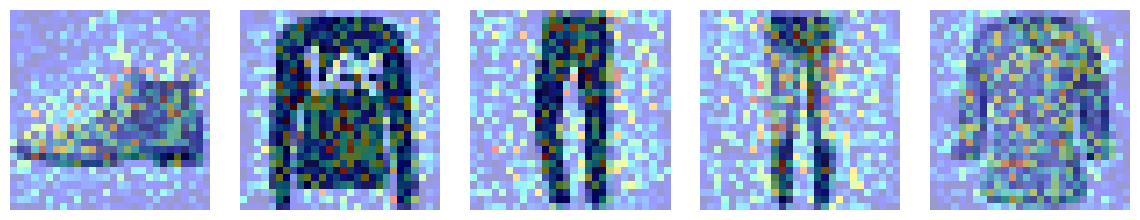



Method: GradientInput


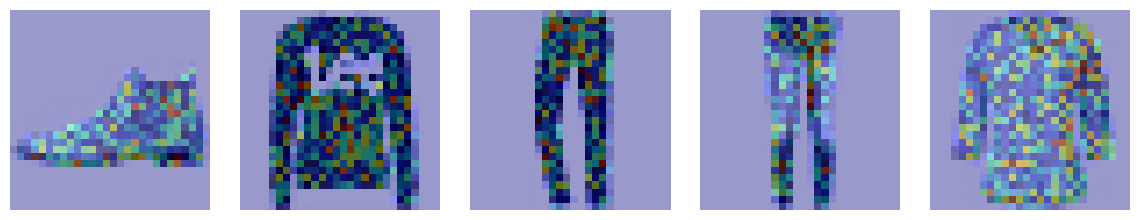

Method: GuidedBackprop


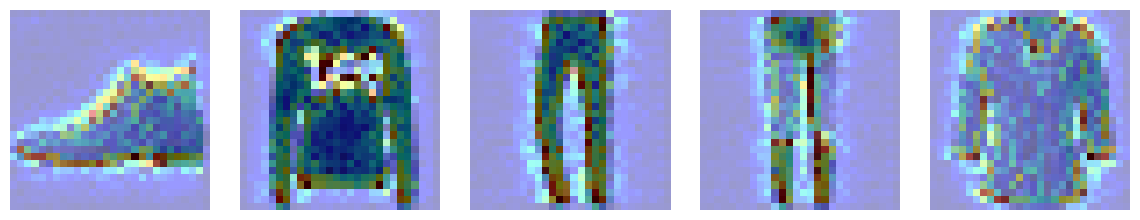



Method: GradCAM


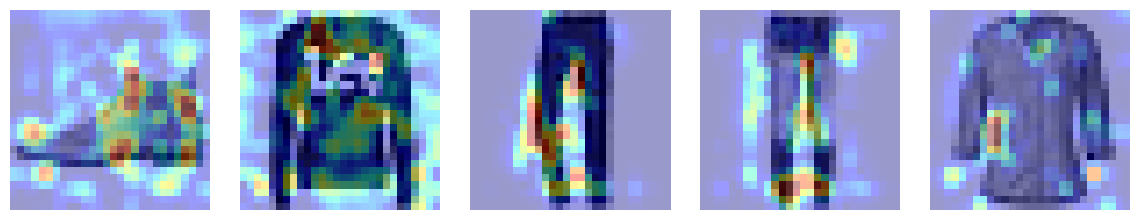



Method: SobolAttributionMethod


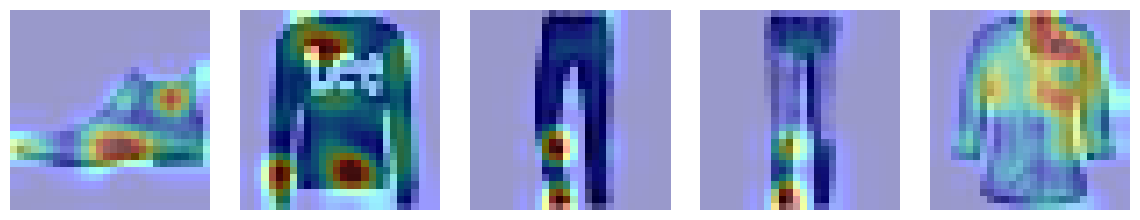

In [50]:
from xplique.attributions.global_sensitivity_analysis.replicated_designs import tf
from xplique.attributions import Saliency, GradientInput, GuidedBackprop, GradCAM, SobolAttributionMethod
import tensorflow.keras.applications as app

X = X_test_mat[:5]
Y = y_test_cat[:5]
model_cnn.layers[-1].activation = tf.keras.activations.linear
batch_size = 64
explainers = [
             Saliency(model_cnn),
             GradientInput(model_cnn),
             GuidedBackprop(model_cnn),
             GradCAM(model_cnn),
             SobolAttributionMethod(model_cnn, batch_size=batch_size)

             ]

for explainer in explainers:

  explanations = explainer(X, Y)

  print(f"Method: {explainer.__class__.__name__}")
  plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)
  plt.show()
  print("\n")